# Exploring the NFL

In [295]:
import nflgame
import numpy as np
#games = nflgame.games(range(2009,2017))

In [2]:
games = nflgame.games(range(2009,2017))
#print len(games)

## Looking play by play

### Tackles by game time

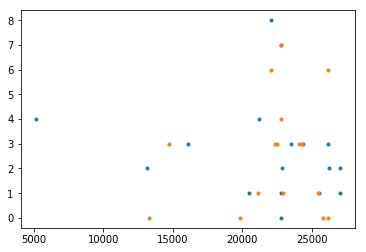

In [135]:
#I'm graphing something at least
def getTacklesByTime(game, team='home'):
    playKeys = game.data[team]['stats']['defense'].keys() #Times of defensive plays
    tackles = []
    for i in playKeys:
        tackles.append(game.data[team]['stats']['defense'][i]['tkl'])
    homeDP = [int(i.replace('-','')) for i in playKeys] 

    combo = sorted(zip(homeDP, tackles))
    return zip(*combo)

time, tackles = getTacklesByTime(games[100])
time2, tackles2 = getTacklesByTime(games[100], team = 'away')
plt.plot(time, tackles, '.')
plt.plot(time2, tackles2, '.')
plt.show()

## Net yards as game progresses

In [555]:
# Gets times of plays and the play objects themselves
def timePlays(game):
    times = []
    plays = []
    for play in game.drives.plays():
        if play.data['time'] == '': continue
        times.append(6000 - 1500*(4-int(play.data['qtr'])) - int(play.data['time'].replace(':','')))
        plays.append(play)
    return times, plays

#Grabs a given stat from all of the plays in the game along with times, the plays themselves, and home/away index
def grabStats(game, toGrab = 'ydsnet'):
    times, plays = timePlays(game)
    indexHome = []
    indexAway = []

    store = [None]*len(plays)
    for i in range(0, len(plays)):
        if(plays[i].team == game.home): indexHome.append(i)
        else: indexAway.append(i)
        
        store[i] = plays[i].data[toGrab]
    return store, times, plays, indexHome, indexAway

#### Graphing net yards for this SD-CIN game

Winner is SD


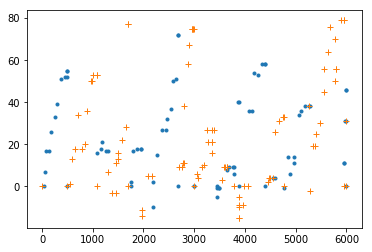

In [631]:
toAnalyze = games[220]

yards, times, plays, indexHome, indexAway = grabStats(toAnalyze)


plt.plot([times[i] for i in indexHome], [yards[i] for i in indexHome], '.')
plt.plot([times[i] for i in indexAway], [yards[i] for i in indexAway], '+')

#print("Average home yards per play is %f from %s" % (np.mean([yards[i] for i in indexHome]), toAnalyze.home))
#print("Average away yards per play is %f from %s" % (np.mean([yards[i] for i in indexAway]), toAnalyze.away))
print("Winner is %s" % toAnalyze.winner)
plt.show()

In [389]:
def grabSpikes(game): #Returns times, yards, and whether it was a home or away
    times, plays = timePlays(game)
    indexHome = []
    indexAway = []

    store = [False]*len(plays)
    for i in range(0, len(plays)):
        if(plays[i].team == game.home): indexHome.append(i)
        else: indexAway.append(i)
        if("spike" in plays[i].desc or "stop the clock" in plays[i].desc):
            store[i] = True
    return store, times, plays, indexHome, indexAway

In [390]:
times, plays = timePlays(games[12])
spikes = grabSpikes(games[12])[0]


allTimes = []
allSpikes = []
for i in range(0, len(games)):
    spikes, times, a, b, c = grabSpikes(games[i])
    allTimes.extend(times)
    allSpikes.extend(spikes)

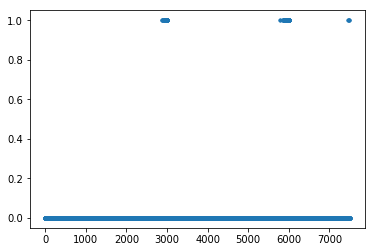

In [393]:
plt.plot(allTimes, allSpikes, '.')
plt.show()

Makes sense. All the spikes occur at the end of games or halfs. 

## Quantifying home team advantage

In [398]:
toCheck = games[54]
drives = toCheck.drives

In [409]:
yards = []
home = []

for j in range(len(games)):
    toCheck = games[j]
    drives = toCheck.drives
    for i in drives:
        yards.append(i.total_yds)
        home.append(i.home)

In [417]:
yards = np.array(yards)

In [429]:
print("Home team drive yards mean %f, sd: %f" % (np.mean(yards[home]), np.std(yards[home])))
print("Away team drive yards mean %f, sd: %f" % (np.mean(yards[np.invert(home)]), np.std(yards[np.invert(home)])))

Home team drive yards mean 29.915055, sd: 28.207665
Away team drive yards mean 28.608894, sd: 27.726298


## Very simple predictions of game result

In [534]:
features = []
homeWin = []


for game in games:
    features.append(game.stats_home[0:10] + game.stats_away[0:10]) #+ (game.score_home,game.score_away))
    homeWin.append(game.winner == game.home)
    
features = np.array(features)
homeWin = np.array(homeWin)

In [535]:
from sklearn import linear_model
np.random.seed(12346)
mask = np.full(len(features), False)
mask[:1600] = True
np.random.shuffle(mask)


clf = linear_model.SGDClassifier(tol=.000001)
clf.fit(features[mask],homeWin[mask])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=1e-06, verbose=0, warm_start=False)

In [548]:
print("Success rate in predicting winner is %f%%" % (100*clf.score(features[np.invert(mask)], homeWin[np.invert(mask)])))

Success rate in predicting winner is 70.758929%


## Scores at Half

In [624]:
scoreDiff = []
winners = []
for game in games:
    scoreAtHalfH = 0
    for i in game.drives:
        if i.result == "End of Half":
                break
        if i.home:
            if i.result=="Touchdown":
                scoreAtHalfH += 7
            elif i.result=="Field Goal":
                scoreAtHalfH += 3
        else:
            if i.result=="Touchdown":
                scoreAtHalfH -= 7
            elif i.result=="Field Goal":
                scoreAtHalfH -= 3
    scoreDiff.append(scoreAtHalfH)
    winners.append(game.winner == game.home)

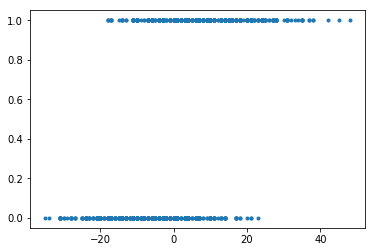

In [630]:
plt.plot(scoreDiff, winners, '.')
plt.show()